In [1]:
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [3]:
#Load Data
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\Classification_Fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv', index_col=0)
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')

#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
district_boundaries['geometry'] = district_boundaries['geometry'].geometry.to_crs(epsg = 4326)
mandal_boundaries['geometry'] = mandal_boundaries['geometry'].geometry.to_crs(epsg = 4326)

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month

#Select complete years (2015-2020)
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= '2015-01-01') & (geo_fire_data['acq_date'] < '2021-01-1')]

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<ipython-input-10-443ba3579c32>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


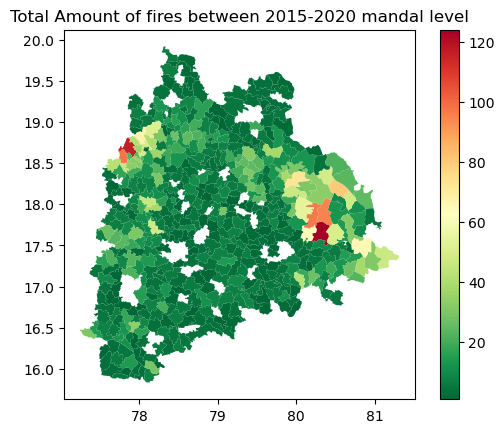

In [10]:
fires = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam'])['fireID'].count().reset_index()

fires_count = fires_count.merge(mandal_boundaries[['Dist_Name', 'Mandal_Nam', 'geometry']], how='left', on=['Dist_Name', 'Mandal_Nam'])

fires_count = gpd.GeoDataFrame(fires_count,geometry = 'geometry', crs = {'init': 'epsg:4326'}) 

fires_count.plot(column = 'fireID', legend = True, cmap = 'RdYlGn_r')
plt.title('Total Amount of fires between 2015-2020 mandal level')
plt.show()

<ipython-input-3-ca761372d940>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')


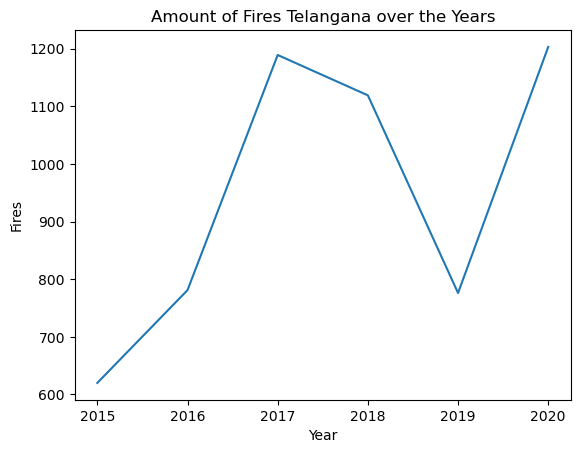

In [3]:
#Create a dataframe that shows the fire location (mandal basis)
fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['year'])['fireID'].count().reset_index()

plt.plot(fires_count['year'], fires_count['fireID'])
plt.title('Amount of Fires Telangana over the Years')
plt.xlabel('Year')
plt.ylabel('Fires')
plt.show()


<ipython-input-4-1a6dc2be2fca>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')


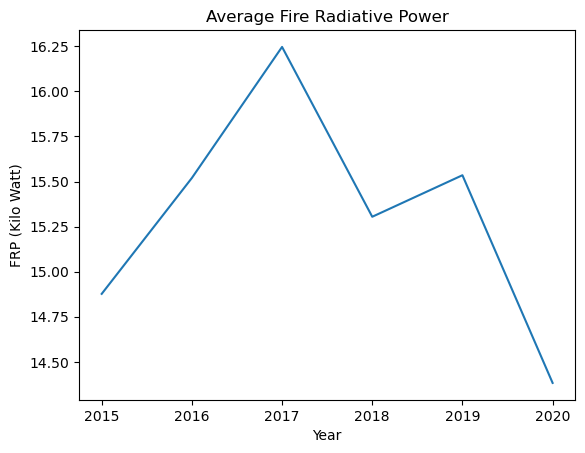

In [4]:
#Create a dataframe that shows the fire location (mandal basis)
fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['year'])['frp'].mean().reset_index()

plt.plot(fires_count['year'], fires_count['frp'])
plt.title('Average Fire Radiative Power')
plt.xlabel('Year')
plt.ylabel('FRP (Kilo Watt)')
plt.show()

In [20]:
fires_per_mandal = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
fires_per_mandal_count = fires_per_mandal.groupby(['Mandal_Nam', 'year',])['fireID'].count().unstack(fill_value=0).stack().reset_index()
fires_per_mandal_count['Fires'] = fires_per_mandal_count[0]
fig = px.line(fires_per_mandal_count, x="year", y='Fires', color='Mandal_Nam', title='Amount of Fires per Mandal in Telangana over the Years')
fig.show()
fig = px.bar(fires_per_mandal_count, x="year", y='Fires', color='Mandal_Nam', title='Amount of Fires per Mandal in Telangana over the Years', barmode='group')
fig.show()
total_fires = fires_per_mandal_count.groupby('Mandal_Nam')['Fires'].sum().reset_index()
total_fires = total_fires.sort_values(by='Fires', ascending = False)
fig = px.bar(total_fires, x='Mandal_Nam', y='Fires', title = 'Total Amount of Fires per Mandal')
fig.show()


<ipython-input-20-511acf62550c>:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326




In [6]:
fires_per_mandal = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
fires_per_mandal_count = fires_per_mandal.groupby(['Mandal_Nam', 'year',])['frp'].mean().unstack(fill_value=0).stack().reset_index()
fires_per_mandal_count['Frp (Kilo Watts)'] = fires_per_mandal_count[0]
fig = px.line(fires_per_mandal_count, x="year", y = 'Frp (Kilo Watts)', color='Mandal_Nam', title='Average Fire Radiative Power per Mandal over the Years')
fig.show()

fig = px.bar(fires_per_mandal_count, x="year", y = 'Frp (Kilo Watts)', color='Mandal_Nam', title='Average Fire Radiative Power per Mandal over the Years', barmode='group')
fig.show()

<ipython-input-6-b7e64363caf0>:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326


